In [1]:
import sys
print(sys.executable)
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

import matplotlib.pyplot as plt
from GraphRicciCurvature.FormanRicci import FormanRicci

/media/alexandre/morespace/data/amgb20/CAM_venv/bin/python


/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at23SavedTensorDefaultHooks11set_tracingEb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.12: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


2.4.0+cpu
2.7.0


## Importing TUDataset (SOCIAL Networks)

| Dataset Name | Reference | Graphs | Classes | Avg. Nodes | Avg. Edges | Node Labels | Edge Labels | Node Attr | Geometry | Edge Attr |
|--------------|-----------|--------|---------|------------|------------|-------------|-------------|-----------|----------|-----------|
| REDDIT-BINARY| [14]      | 2000   | 2       | 429.63     | 497.75     | –           | –           | –         | –        | –         |
| IMDB-BINARY  | [14]      | 1000   | 2       | 19.77      | 96.53      | –           | –           | –         | –        | –         |
| MUTAG        | [1,23]    | 188    | 2       | 17.93      | 19.79      | –           | –           | –         | –        | –         |
| ENZYMES      | [4,5]     | 600    | 6       | 32.63      | 62.14      | –           | –           | –         | –        | –         |
| PROTEINS     | [4,6]     | 1113   | 2       | 39.06      | 72.82      | –           | –           | –         | –        | –         |
| COLLAB       | [14]      | 5000   | 3       | 74.49      | 2457.78    | –           | –           | –         | –        | –         |

In [2]:
from torch_geometric.datasets import TUDataset

def load_dataset(dataset_name):
    dataset_benchmark = {"REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS", "COLLAB"}
    
    if dataset_name in dataset_benchmark:
        dataset = TUDataset(root='./data', name=dataset_name)
        return dataset
    else:
        raise ValueError(f"Dataset {dataset_name} is not in the benchmark list.")

# Macro to load dataset
def set_dataset(name):
    global dataset
    dataset = load_dataset(name)
    print(f"Loaded dataset: {dataset}")
    return dataset

# Example usage:
dataset_name = "REDDIT-BINARY"  # Change this to the dataset you want to work with
dataset = set_dataset(dataset_name)


Loaded dataset: REDDIT-BINARY(2000)


In [3]:
#Get other dependencies
import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv, eigvalsh

print(f"REDDIT-BINARY dataset has {len(dataset)} graphs")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Extract first graph {dataset[0]} which has {dataset[0].num_nodes} nodes and {dataset[0].edge_index.shape[1]} edges with this graph being of class y={dataset[0].y}")

redGraph = dataset[0]
edge_index = redGraph.edge_index.numpy().T # (480, 2) --> (edges, pairs)
G_red = nx.Graph()
G_red.add_edges_from(edge_index)

REDDIT-BINARY dataset has 2000 graphs
Number of features: 0
Number of classes: 2
Number of edge features: 0
Extract first graph Data(edge_index=[2, 480], y=[1], num_nodes=218) which has 218 nodes and 480 edges with this graph being of class y=tensor([1])


## Plotting the graph

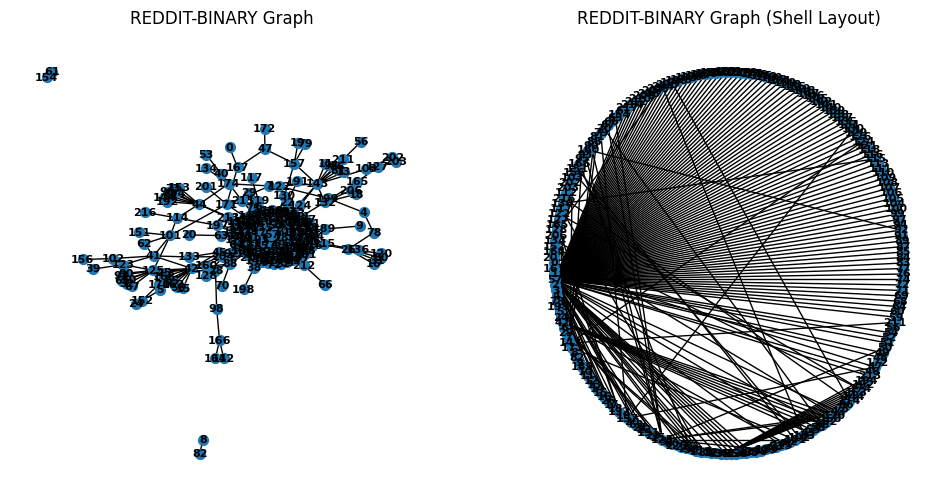

In [4]:
from visualization.networkx_plot import *
plot_dataset_net(G_red, dataset_name)

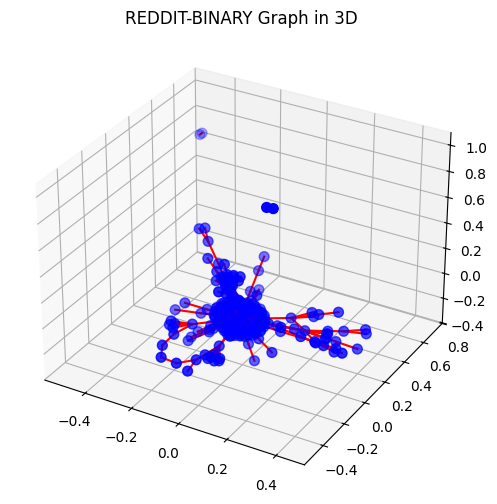

In [5]:
plot_dataset_net_3D(G_red, dataset_name)

Get graph diameter which is the length of the shortest path between the most distanced nodes

In [6]:
#Function to get diameter

def get_diameter(G):
    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        diameter = max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))

    return diameter

print("Reddit Graph Diameter:", get_diameter(G_red))

Reddit Graph Diameter: 8


In [7]:
#Function to convert dataset to a NetworkX Representation
def make_G(dataset):
    graph = dataset[0]
    edge_index = graph.edge_index.numpy().T
    G = nx.Graph()
    G.add_edges_from(edge_index)

    return G

In [8]:
red_G = make_G(dataset)
print(get_diameter(red_G))

8


## Effective resistance

The effective resistance is measures how easily information flows between pairs of nodes. If rewiring reduces effective resistance, it improves communication efficiency:

$$[ R_{uv} = L^+{uu} + L^+{vv} - 2L^+_{uv} ]$$



where $R_{ij}$ is the resistance between nodes $i$ and $j$ in the graph.


In [9]:
from evaluation.metrics import *

print(get_eff_res(red_G))

3.0027688909524195


## Modularity

Quantifies how well the graph divides into clusters or communities. If rewiring disrupts modularity, it may indicate loss of local structure.

$$Q = \sum_{c=1}^{n}
       \left[ \frac{L_c}{m} - \gamma\left( \frac{k_c}{2m} \right) ^2 \right]$$

where the sum iterates over all communities $c$, $m$ is the number of edges, $L_c$ is the number of intra-community links for community $c$, $k_c$ is the sum of degrees of the nodes in community $c$, and $\gamma$ is the resolution parameter.

In [10]:
print(get_modularity(red_G))

0.5892013888888892


## Graph Assortativity

Measures if nodes tend to connect to others with similar degree. A change in assortativity indicates whether high/low-degree nodes are rewired differently.

$$r = \frac{\sum_{ij} ij (e_{ij} - q_i q_j)}{\sigma^2}$$

where $e_{ij}$ is the fraction of edges connecting nodes of degree $i$ and $j$, $q_i$ is the fraction of edges connected to nodes of degree $i$, and $\sigma^2$ is the variance of the degree distribution.

In [11]:
print(get_assort(red_G))

-0.4046069146077361


## Clustering Coefficient

Measures how likely a node’s neighbors are to be connected to each other. Increasing clustering after rewiring may improve local information sharing.

$$C = \frac{1}{n}\sum_{v \in G} c_v$$

where :math:`n` is the number of nodes in `G`.

In [12]:
print(get_clust_coeff(red_G))

0.04106324376158407


## Graph Laplacian Eigenvalues (Spectral Gap):

The second smallest eigenvalue (λ1\lambda_1λ1​) of the Laplacian indicates how well-connected the graph is. A larger spectral gap after rewiring suggests better robustness and connectivity.

ADD formula

where $f$ is a non-zero vector orthogonal to the all-ones vector $\mathbf{1}$, $L$ is the Laplacian matrix, and $f^T$ denotes the transpose of $f$.

In [13]:
print(get_spec_gap(red_G))

-1.4843147902492153e-16


❗️ **NOTE:** above might be wrong btw

## Forman-Ricci curvature F(i,j)

A computationally simpler alternative to Ollivier-Ricci, used for edge-based curvature analysis. While F(i,j) is given in terms of combinatorial quantities, results are scarce and the definition is biased towards negative curvature.

In [14]:
from evaluation.curvature import *
# print(get_forman_curve(red_G))
print(get_Forman_curve(red_G))


0.0


An average curvature of 1.0 indicates that the graph red_G has a positive and moderately connected structure. The nodes tend to have low degrees, and the edges are part of well-connected regions, contributing to the overall robustness and connectivity of the graph

## Results of metrics methods

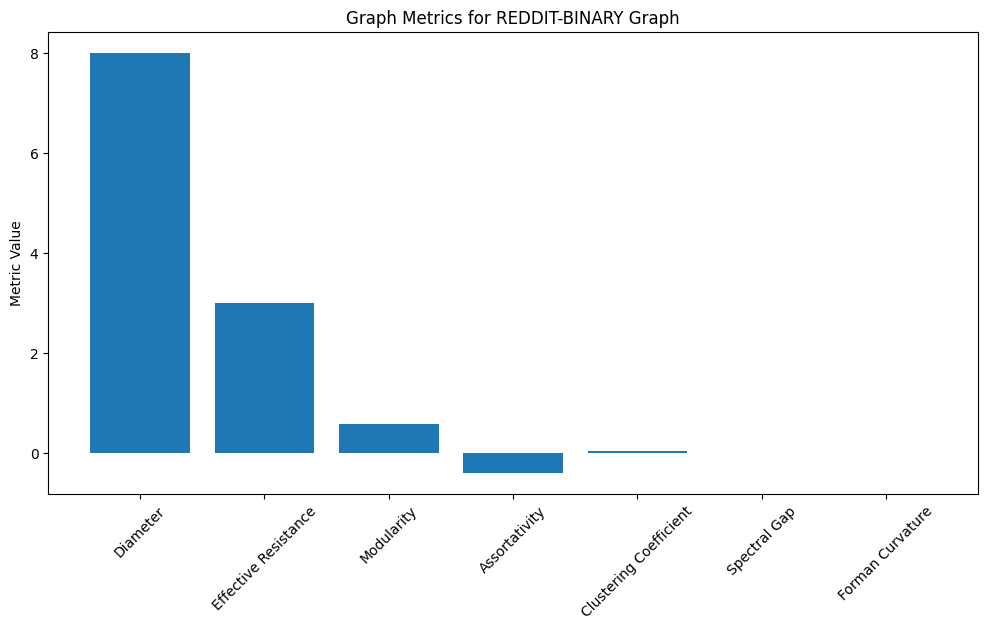

In [15]:
# create an histogram calling all the metric for the graph red_G

def get_metrics(G):
    metrics = {
        "Diameter": get_diameter(G),
        "Effective Resistance": get_eff_res(G),
        "Modularity": get_modularity(G),
        "Assortativity": get_assort(G),
        "Clustering Coefficient": get_clust_coeff(G),
        "Spectral Gap": get_spec_gap(G),
        # "Forman Ricci Curvature": get_forman_curve(G),
        "Forman Curvature": get_Forman_curve(G)
    }
    
    return metrics

metrics = get_metrics(red_G)

# plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(metrics.keys(), metrics.values())
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.title("Graph Metrics for REDDIT-BINARY Graph")
plt.show()



----

# Rewiring the graph

## SDRF

In [18]:
dataset_name = "REDDIT-BINARY"
dataset = set_dataset(dataset_name)

redGraph = dataset[0]
red_G = make_G(dataset)

from rewiring.sdrf.sdrf import SDRFTransform

sdrf = SDRFTransform(num_iterations=50, dataset='REDDIT-BINARY')

rewired_graph_sdrf = sdrf.transform(redGraph)

rewired_graph_sdrf_index = rewired_graph_sdrf.edge_index_numpy().T

rewired_G_sdrf = nx.Graph()
rewired_G_sdrf.add_edges_from(rewired_graph_sdrf_index)

print(f"Rewiring complete! New graph has {rewired_G_sdrf.number_of_edges()} edges.")



Loaded dataset: REDDIT-BINARY(2000)


TypeError: argument of type 'method' is not iterable

## FOSR

In [ ]:
dataset_name = "REDDIT-BINARY"
dataset = set_dataset(dataset_name)

redGraph = dataset[0]
red_G = make_G(dataset)

from rewiring.fosr.fosr import FOSRTransform

# Apply FOSR on the first graph
fosr = FOSRTransform(num_iterations=50, initial_power_iters=5, dataset='REDDIT-BINARY')

# Apply FOSR transformation
rewired_graph_fosr = fosr.transform(redGraph)

# Extract rewired edge index
rewired_edge_fosr_index = rewired_graph_fosr.edge_index.numpy().T

# Convert rewired graph to NetworkX for metric comparison
rewired_G_fosr = nx.Graph()
rewired_G_fosr.add_edges_from(rewired_edge_fosr_index)

print(f"Rewiring complete! New graph has {rewired_G_fosr.number_of_edges()} edges.")

Loaded dataset: REDDIT-BINARY(2000)
Rewiring complete! New graph has 290 edges.


## Testing a rewired technique Double Edge Swap

Swap two edges in the graph while keeping the node degrees fixed: [NetworkX Double Edge Swap](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html)

❓ QUESTIONS?
If you want to do rewiring in a graph with this method for eg, one of the argument is the number of double-edge swaps to perform for each edge in the graph. How do you decide the number of edge swaps to perform? For eg we have 480 edges in the first graph of REDDIT-BINARY dataset. How many swaps should we perform?

Diameter: Not Improved
Effective Resistance: Not Improved
Modularity: Not Improved
Assortativity: Improved
Clustering Coefficient: Improved
Spectral Gap: Not Improved
Forman Curvature: Not Improved


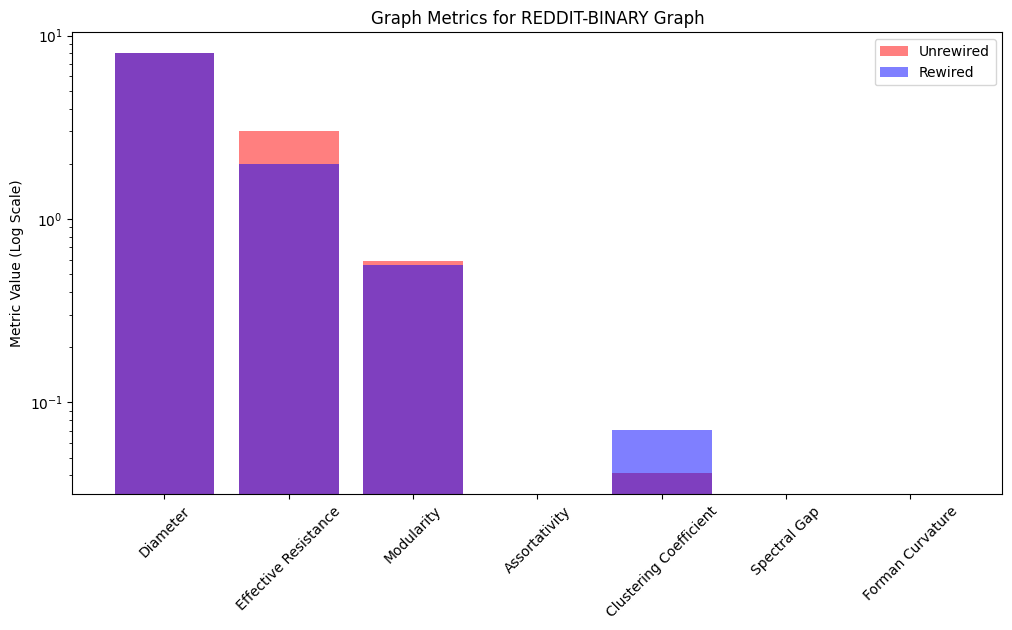

In [ ]:
# gets metrics for unrewired graph
metrics_unrewired = get_metrics(red_G)

# copy of the original graph
rewired_G = red_G.copy()

# double-edge swap on the copied graph
nx.double_edge_swap(rewired_G, nswap=100, max_tries=500)

# get metrics for rewired graph
metrics_rewired = get_metrics(rewired_G)

# 1 - depending on the interpretation of each metric, assert a text that's says if we improved or not
# FIXME: I think this is wrong since metrics dont have a fixed interpretation and some of them might need inferior to rewired or whatever

for metric, value in metrics_unrewired.items():
    if metrics_rewired[metric] > value:
        print(f"{metric}: Improved")
    else:
        print(f"{metric}: Not Improved")
        

# 2 - plot the histograms of the metrics for the unrewired and rewired graphs to a certain scale because the values are different
plt.figure(figsize=(12, 6))
plt.bar(metrics_unrewired.keys(), metrics_unrewired.values(), alpha=0.5, label='Unrewired', color='r')
plt.bar(metrics_rewired.keys(), metrics_rewired.values(), alpha=0.5, label='Rewired', color='b')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel("Metric Value (Log Scale)")
plt.title("Graph Metrics for REDDIT-BINARY Graph")
plt.legend()
plt.show()